# TITLE

## Import modules

In [1]:
import pandas as pd
import numpy as np
import re

## Create per cell categorical matrix outputs from label dataset

In [2]:
raw_output_path = '../exported_annotations/cellAnnotations.csv'
label_data = pd.read_csv(raw_output_path)

In [3]:
simple_label_dict = {'Data':2,'Header':1,'Notes':0,'Other':0,'MetaTitle':0,'Derived':0,'GroupHead':0}
label_data['AnnotationLabel_Simple'] = label_data['AnnotationLabel'].map(simple_label_dict)

In [4]:
file_names = list(label_data['FileName'].unique())

In [5]:
def column_string_to_num(s):
    n = ord(s[-1]) - 64
    if s[:-1]:
        return 26 * (column_string_to_num(s[:-1])) + n
    else:
        return n

def separate_number_chars(s):
    res = re.split('([-+]?\d+\.\d+)|([-+]?\d+)', s.strip())
    res_f = [r.strip() for r in res if r is not None and r.strip() != '']
    return res_f


# document for loop begins here 
output_data = []
for filename in file_names[0:50]:
    single_document = label_data[label_data['FileName'] == filename]
    sheets = single_document['SheetName'].unique()
    for sheet in sheets:
        # sheet for loop begins here 
        single_document_sheet = single_document[single_document['SheetName'] == sheet]
        
        output_list = []
        max_col = 0
        max_row = 0
        for n in range(0,len(single_document_sheet)): #should be optimized to be vectorized not for loop 
            record = single_document_sheet[['AnnotationAddress','AnnotationLabel_Simple']].iloc[n]
            cell_ref = record['AnnotationAddress']
            col_ref_letter = separate_number_chars(cell_ref)[0]
            col_ref = int(column_string_to_num(col_ref_letter)) -1 #for python 0 index
            row_ref = int(separate_number_chars(cell_ref)[1]) -1 #for python 0 index
            label = record['AnnotationLabel_Simple']
            output_list.append((col_ref, row_ref, label))
            if col_ref > max_col:
                max_col = col_ref
            if row_ref > max_row:
                max_row = row_ref
                
        label_matrix = np.zeros((max_row+1,max_col+1))
        for col_ref,row_ref,label in output_list:
            label_matrix[row_ref,col_ref] = label
        output_data.append((filename,sheet,label_matrix))

In [6]:
output_data[0][2].shape

(44, 19)

In [7]:
y_train = np.array([x[2] for x in output_data])

In [8]:
y_train[0].shape

(44, 19)

## Create multi-dimensional matrix inputs from raw spreadsheet inputs

In [9]:
def check_if_empty(y):
    if str(y) == "nan":
        return 1
    else:
        return 0

raw_input_dir = '../dataset/completed/'
input_data = []
for outputs in output_data:
    filename = outputs[0]
    sheet = outputs[1]
    full_file = raw_input_dir + str(filename)
    df = pd.read_excel(full_file,header=None,sheet_name=sheet)
    
    raw_matrix = np.array(df)
    #print(raw_matrix.shape)
    
    type_matrix = np.array([[type(y).__name__ for y in x] for x in raw_matrix])
    #print(type_matrix.shape)
    
    isempty_matrix = np.array([[check_if_empty(y) for y in x] for x in raw_matrix])
    #print(isempty_matrix.shape)
    
    #TODO
    ## import openpyxl get colour and format 
    
    input_matrix = np.dstack((raw_matrix,type_matrix,isempty_matrix))
    input_data.append((filename,sheet,input_matrix))

In [10]:
input_data[0][2].shape

(44, 19, 3)

In [11]:
X_all = np.array([x[2] for x in input_data])

In [12]:
X_all.shape

(50,)

# Shallow Implimentation

In [110]:
# each row is a cell with cell attributes 

dfinput = pd.DataFrame()

raw_input_dir = '../dataset/completed/'
input_data = []
for outputs in output_data:
    filename = outputs[0]
    sheet = outputs[1]
    labels = list(outputs[2].flatten())
    print("labels", len(labels))

    full_file = raw_input_dir + str(filename)
    df = pd.read_excel(full_file,header=None,sheet_name=sheet)  
    print("df", len(df))

    data_list = []
    cols = df.columns
    for col in cols:
        for index, row in df.iterrows():
            value = row[cols[0]]
            data_dict = {}
            #data_dict['cell_value'] = value

            data_dict['cell_row'] = index
            data_dict['cell_col'] = col


            dtype = str(type(value).__name__)
            data_dict['cell_dtype'] = dtype
            if str(value).lower() == 'nan':
                data_dict['not_null'] = 0
            else:
                data_dict['not_null'] = 1
            string_value = str(value)    
            numbers = sum(c.isdigit() for c in string_value)
            data_dict['count_numbers'] = numbers
            letters = sum(c.isalpha() for c in string_value)
            data_dict['count_letters'] = letters
            spaces  = sum(c.isspace() for c in string_value)
            data_dict['count_spaces'] = spaces
            others  = len(s) - numbers - letters - spaces
            data_dict['count_others'] = others
            data_dict['prop_digits'] = numbers / len(string_value)
            data_dict['str_length'] = len(string_value)
            if "%" in string_value:
                data_dict['contains_%'] = 1
            else:
                data_dict['contains_%'] = 0
            if "." in string_value:
                data_dict['contains_.'] = 1
            else:
                data_dict['contains_.'] = 0
            data_list.append(data_dict) 
    dfout = pd.DataFrame(data_list)
    dfout['cell_dtype'] = dfout['cell_dtype'].astype('category')
    dfout['cell_dtype'] = dfout['cell_dtype'].cat.codes
    print("dfout",len(dfout))
    try:
        dfout['label'] = labels
        dfinput = dfinput.append(dfout)
    except:
        print("issue with file", full_file)

labels 836
df 44
dfout 836
labels 11028
df 919
dfout 11028
labels 7289
df 197
dfout 7289
labels 460
df 46
dfout 460
labels 252
df 36
dfout 252
labels 6870
df 458
dfout 6870
labels 668
df 167
dfout 668
labels 150
df 61
dfout 610
issue with file ../dataset/completed/andrew_lewis__72__Exxon Gulf Coast 0401.xlsx
labels 1345
df 269
dfout 1345
labels 3707
df 337
dfout 3707
labels 176
df 22
dfout 286
issue with file ../dataset/completed/andrew_lewis__96__CrackSpreadOptions.xlsx
labels 952
df 139
dfout 1112
issue with file ../dataset/completed/andrew_lewis__99__10-29-01.xlsx
labels 666
df 37
dfout 666
labels 48
df 8
dfout 48
labels 440
df 40
dfout 680
issue with file ../dataset/completed/andy_zipper__134__ICE - Mar05 Power & Gas VOL.xlsx
labels 1089
df 99
dfout 1089
labels 225
df 25
dfout 225
labels 144
df 36
dfout 144
labels 198
df 22
dfout 198
labels 468
df 39
dfout 468
labels 231
df 33
dfout 231
labels 320
df 32
dfout 384
issue with file ../dataset/completed/barry_tycholiz__824__PGT LC Ship

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X = dfinput.drop("label",axis=1)
y = dfinput['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [113]:
dfinput.isnull().sum()/len(dfinput) * 100


cell_row         0.0
cell_col         0.0
cell_dtype       0.0
not_null         0.0
count_numbers    0.0
count_letters    0.0
count_spaces     0.0
count_others     0.0
prop_digits      0.0
str_length       0.0
contains_%       0.0
contains_.       0.0
label            0.0
dtype: float64

In [114]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(X_train,y_train)

/home/samuel/python_envs/anaconda3/envs/py36_sk/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=0)

In [115]:
y_pred = model.predict(X_test)

In [ ]:
 from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=target_names))

## Reshape data dimensionality and pad inputs/outputs

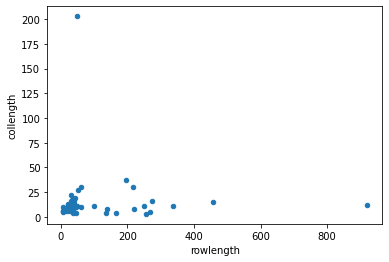

In [434]:
rowlist = []
collist = []
for tup in input_data:
    rowlist.append(tup[2].shape[0])
    collist.append(tup[2].shape[1])
dfdim = pd.DataFrame({'rowlength':rowlist,'collength':collist})
dfdim.plot.scatter(x='rowlength',y='collength')

In [435]:
row_max = dfdim['rowlength'].max() +1 #just+1 to make even better to round up to next even to do properly
col_max = dfdim['collength'].max() +1
row_max,col_max

(920, 204)

In [436]:
# Need a function that takes each 'layer' assesses its data type, creates padded matrix
# full of the null value for that data type, adds the original values top left, and then
# stitches all layers back together

def get_categorical_mapping(X_all):
    mapping_dict = {}
    l = list([x[:,:,1] for x in X_all])
    l1 = [item for sublist in l for item in sublist]
    flat_list = [item for sublist in l1 for item in sublist]
    unique_list = list(set(flat_list))
    for index,value in enumerate(unique_list):
        mapping_dict[value] = index + 1
    return mapping_dict
mapping_dict = get_categorical_mapping(X_all)
mapping_dict

{'float': 1, 'Timestamp': 2, 'datetime': 3, 'NaTType': 4, 'int': 5, 'str': 6}

In [437]:
for index,X in enumerate(X_all):
    encoded_list = [[mapping_dict[y] for y in x] for x in X[:,:,1]]
    encoded_matrix =np.array([np.array(xi) for xi in encoded_list])
    X[:,:,1] = encoded_matrix


#np.apply_along_axis(my_func, 1, X_all[0][:,:,1],mapping_dict=mapping_dict)

In [438]:
# OK NEED TO FIGURE OUT HOW WE WANT TO REPRESENT STRINGS

# num_dimensions = X_all[0].shape[2]

# padded_string_matrix_list = []
# for n in range(0,len(X_all)):
#     print(n)
#     empty_char_array = np.chararray((row_max,col_max),itemsize=128,unicode=False)
#     empty_char_array[:,:] = 'nan'
#     empty_char_array.shape
#     empty_char_array
#     a = X_all[n][:,:,0]
#     empty_char_array[:a.shape[0],:a.shape[1]] = a
#     padded_string_matrix_list.append(empty_char_array)

In [439]:
def pad_matrix(X_all,dim):
    padded_matrix_list = []
    for n in range(0,len(X_all)):
        padded_matrix = np.zeros((row_max,col_max))
        #padded_matrix[:,:] = -1 # different default
        a = X_all[n][:,:,dim]
        padded_matrix[:a.shape[0],:a.shape[1]] = a
        padded_matrix_list.append(padded_matrix)
    padded_matrix = np.array(padded_matrix_list)
    return padded_matrix

In [440]:
A = pad_matrix(X_all,dim=1)

In [441]:
B = pad_matrix(X_all,dim=2)

In [442]:
X_all_padded = np.stack((A,B))
X_all_padded_ordered = np.moveaxis(X_all_padded, 0, 3)

X_all_padded_ordered.shape

(50, 920, 204, 2)

In [443]:
X_train = X_all_padded_ordered

In [444]:
row_max

920

In [445]:
padded_matrix_list = []
for a in y_train:
    padded_matrix = np.zeros((row_max,col_max))
    padded_matrix[:a.shape[0],:a.shape[1]] = a
    padded_matrix_list.append(padded_matrix)
Y_all = np.array(padded_matrix_list)

In [446]:
padded_matrix.shape

(920, 204)

In [447]:
y_train = Y_all
y_train = y_train.reshape((50,920,204,1))

In [401]:
y_train.shape

(50, 919, 203, 1)

## Build CNN

In [379]:
row_max,col_max

(919, 203)

In [388]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(row_max,col_max,2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
#model.add(Flatten())

model.add(Dense(1, activation='softmax',input_shape = (row_max,col_max)))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [389]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 917, 201, 64)      1216      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 915, 199, 32)      18464     
_________________________________________________________________
dense_15 (Dense)             (None, 915, 199, 1)       33        
Total params: 19,713
Trainable params: 19,713
Non-trainable params: 0
_________________________________________________________________


In [375]:
model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=3)

ValueError: Error when checking target: expected dense_10 to have shape (915, 199, 1) but got array with shape (919, 203, 1)

In [ ]:
# To deal with variable input size

## padding right and down to make all same size with lots of irrelevant in the bottom - 
    # kind of need to know the size of a maximum spreadhseet for this though which could kind of be anything 
    # hummm
    
## #input_shape=(1, None, None)
    # None in a shape denotes a variable dimension. Note that not all layers will work with such variable 
    # dimensions, since some layers require shape information (such as Flatten).

In [ ]:
# TODO

# take the inputs 
# Feed them into a simple Neural Network 
# Make the output later the relevant output data (same dimensions as input)
# Figure out how to deal with variable input lengths 
# Get it to predict the output layers 0,1,2
# See it can overfit with perfect overfitting with simple NN architecture
# See the real performmance with train/test set
# Make the architeture more complex look at CNN standard architectures 
# See how good you can get the perofmrance 